In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics as mt

In [81]:
#loading dataset

df = pd.read_csv("/Users/muskaanmahes/Downloads/full_dataset.csv")
df               

,Student_ID,Age,Gender,Degree,Branch,CGPA,Internships,Projects,Coding_Skills,Communication_Skills,Aptitude_Test_Score,Soft_Skills_Rating,Certifications,Backlogs,Placement_Status
0,1048,22,Female,B.Tech,ECE,6.29,0,3,4,6,51,5,1,3,Not Placed
1,37820,20,Female,BCA,ECE,6.05,1,4,6,8,59,8,2,1,Not Placed
2,49668,22,Male,MCA,ME,7.22,1,4,6,6,58,6,2,2,Not Placed
3,19467,22,Male,MCA,ME,7.78,2,4,6,6,90,4,2,0,Placed
4,23094,20,Female,B.Tech,ME,7.63,1,4,6,5,79,6,2,0,Placed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,40640,19,Female,MCA,Civil,4.91,0,1,1,5,47,5,0,3,Not Placed
49996,46999,20,Male,B.Tech,ECE,6.82,2,3,5,7,76,6,2,0,Placed
49997,3816,20,Male,BCA,IT,5.80,0,3,6,7,56,6,2,2,Not Placed
49998,41368,23,Female,B.Tech,IT,7.67,1,4,7,6,67,4,2,0,Placed


In [82]:
#dropping ID 
df.drop(columns = ["Student_ID"])

#impute missing values by grouping Degree and Branch
df_group = df.groupby(by=['Degree', 'Branch'])

#fill in numeric values: group median
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df_group[numeric_columns].transform(
    lambda grp: grp.fillna(grp.median())
)


#fill in the categorical values using group mode
categorical_columns = df.select_dtypes(include=['object']).columns
df_categorical = df_group[categorical_columns].apply(
    lambda grp: grp.fillna(grp.mode().iloc[0])
)

#combining numeric and categorical
df_imputed = pd.concat([df_numeric, df_categorical], axis = 1)


# fill in the grouped variables from original data frame
df_imputed[['Degree', 'Branch']] = df[['Degree', 'Branch']]

# Create discrete features agains now with the newest values
df_imputed['cgpa_range'] = pd.cut(
    df_imputed['CGPA'],
    bins=[0, 5.5, 7.0, 8.5, 10.01],
    labels=[0, 1, 2, 3],
    include_lowest=True
)

#drop rows with missing values
df_imputed.dropna(inplace=True)
df_imputed['cgpa_range'] = df_imputed['cgpa_range'].astype(int)

df_imputed = df.copy()

    

In [83]:
#train/test split

#performing one hot encoding on categorical data
df_encoded = pd.get_dummies(df_imputed, columns=['Gender', 'Degree', 'Branch'], drop_first=True)
                                          
#predict the X and y data
y = df_encoded['Placement_Status'].values
X = df_encoded.drop(columns=['Placement_Status']).values

#CV 
cv_object = ShuffleSplit(n_splits =3, test_size = 0.2, random_state=14)

print(cv_object)



ShuffleSplit(n_splits=3, random_state=14, test_size=0.2, train_size=None)


In [84]:
# logistic regression with all features

#creating logistic regression object with diff learning paramaters and constants
lr_clf = LogisticRegression(C=1.0, class_weight=None, solver= 'liblinear')


#training loop 
iter_num=0
for train_idx, test_idx in cv_object.split(X,y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    #standarizing features to have mean = 0 & sd =1
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #train the lr model on the training data
    lr_clf.fit(X_train_scaled, y_train)
    y_hat = lr_clf.predict(X_test_scaled)

    #evaluate
    accuracy = mt.accuracy_score(y_test, y_hat)
    conf = mt.confusion_matrix(y_test, y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", accuracy )
    print("confusion matrix\n",conf)
    iter_num+=1

    
                            

====Iteration 0  ====
accuracy 0.8689
confusion matrix
 [[5772  609]
 [ 702 2917]]
====Iteration 1  ====
accuracy 0.8736
confusion matrix
 [[5808  608]
 [ 656 2928]]
====Iteration 2  ====
accuracy 0.868
confusion matrix
 [[5695  645]
 [ 675 2985]]


Logistic Regression Accuracy (important features): 0.8673


/opt/anaconda3/envs/DS7331/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


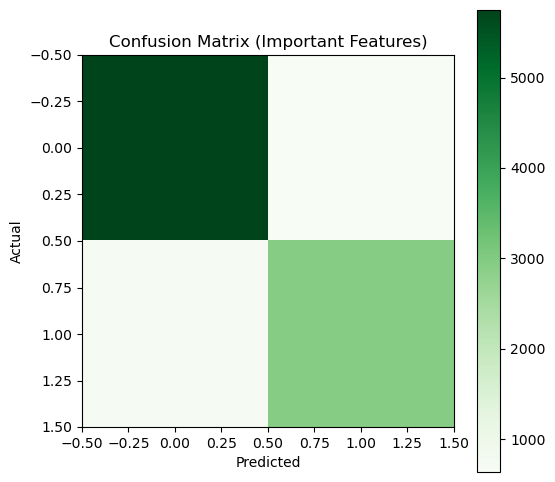

In [99]:
#running the logisitic regression with the chosen/important features
# top features chosen from last lab
top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

df_top = df_encoded[top_features + ['Placement_Status']]

# split the features and labels
X = df_top.drop(columns=['Placement_Status']).values
y = df_top['Placement_Status'].values

# 3. CV
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 4. Logistic Regression model 
lr_clf = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',  # or 'lbfgs' if you prefer
    max_iter=1000
)

#Train/test loop
scaler = StandardScaler()

for train_idx, test_idx in cv.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    lr_clf.fit(X_train_scaled, y_train)

    # Predict
    y_hat = lr_clf.predict(X_test_scaled)

    # Evaluate
    acc = mt.accuracy_score(y_test, y_hat)
    conf = mt.confusion_matrix(y_test, y_hat)


print(f"Logistic Regression Accuracy (important features): {acc:.4f}")

plt.figure(figsize=(6, 6))
plt.imshow(conf, cmap='Greens')
plt.title("Confusion Matrix (Important Features)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
#running the logisitc regression with gradient descent

from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt


#setup
regularize_const = 0.0001
iterations = 150
cv = ShuffleSplit(n_splits = 1, test_size=0.2, random_state =3)
 
log_sgd = SGDClassifier(
    alpha=regularize_const,
    fit_intercept=True,
    l1_ratio=0.0,
    learning_rate='optimal',
    loss='log_loss',
    n_iter_no_change=iterations,
    n_jobs=-1,
    penalty='l2'

)

scl = StandardScaler()

#traing loop
for train_idx, test_idx in cv.split(X, y):
    log_sgd.fit(X_train_scaled, y[train_idx])
    X_train_scaled = scl.fit_transform(X[train_idx])
    X_test_scaled = scl.transform(X[test_idx])
    
    yhat = log_sgd.predict(X_test_scaled)

    conf = mt.confusion_matrix(y[test_idx], yhat)
    acc = mt.accuracy_score(y[test_idx], yhat)
print('Logistic Regression:', acc)

#plot cm
plt.figure(figsize=(6, 6))
plt.imshow(conf, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

    

In [90]:
#SVM 
from sklearn.svm import SVC

#defining the top featues based on importance 
top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

df_top = df_encoded[top_features + ['Placement_Status']]

#define new x and y
y = df_top['Placement_Status'].values
X = df_top.drop(columns=['Placement_Status']).values

# CV
cv_object = ShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

#fit the model
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


#training SVM model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, y_train)

#predict
y_hat = svm_clf.predict(X_test_scaled)

#Evaluate
accuracy = mt.accuracy_score(y_test, y_hat)
conf = mt.confusion_matrix(y_test, y_hat)

print('accuracy:', accuracy )
print(conf)

#look at support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )



accuracy: 0.9923
[[6307   38]
 [  39 3616]]
(2602, 7)
(2602,)
[1304 1298]


In [100]:
#svm with linear kernel

#defining the top featues based on importance 
top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

df_top = df_encoded[top_features + ['Placement_Status']]

#define new x and y
y = df_top['Placement_Status'].values
X = df_top.drop(columns=['Placement_Status']).values

# CV
cv_object = ShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

#fit the model
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


#training SVM model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, y_train)

#predict
y_hat = svm_clf.predict(X_test_scaled)

#Evaluate3
accuracy = mt.accuracy_score(y_test, y_hat)
conf = mt.confusion_matrix(y_test, y_hat)

print('accuracy:', accuracy )
print(conf)

#look at support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )


accuracy: 0.873
[[5682  663]
 [ 607 3048]]
(13229, 7)
(13229,)
[6614 6615]
